# **Implementación de redes neuronales convolucionales para la extracción de características de agujeros negros**

---
**Universidad Nacional de Colombia**

Realizado por:
- Fabián R. Hernández Gáfaro
- Manuel A. Herrera Arias
- Juan E. Millán Díaz
- Nelson A. Rodríguez Mora
- Juan C. Sánchez Tovar
- Daniel G. Vargas Wilches



Se importan las librerías necesarias para la red. La arquitectura será realizada con ayuda de Tensorflow, se usará matplotlib para realizar las gráficas necesarias, y se cargan funciones de sklearn para el procesamiento de los datos y las evaluaciones finales del modelo.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Se cargan los datos, 'images_data' contiene los datos de las imágenes, cada pixel tiene un valor entre 0 y 0.5. Por su parte, 'labels' contiene los valores del espín (entre 0 y 1) y el ángulo de inclinación (entre 0 y 90 grados) de cada agujero negro.

In [2]:
images_data = np.load('/content/images_data.npy')
labels = np.load('/content/labels.npy')

In [3]:
print(f'Tamaño de las imagenes: {images_data.shape}')
print(f'Tamaño de los labels: {labels.shape}')

Tamaño de las imagenes: (1900, 150, 84)
Tamaño de los labels: (1900, 2)


In [4]:
print(labels[50], labels[501], labels[1000])

[ 0.81616174 88.51130515] [ 0.50104723 69.99062828] [0.33327699 7.66482762]


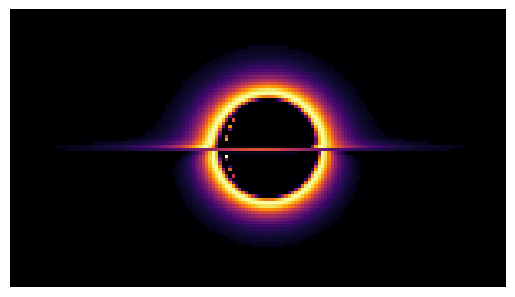

In [5]:
plt.imshow(images_data[50].T, origin='lower', cmap='inferno')
plt.axis('off')
plt.show()

In [6]:
labels[0]

array([ 0.64349129, 63.0870336 ])

Procedemos a normalizar los valores de los ángulos de inclinación, por comodidad de la red.

In [7]:
labels[:, 1] /= 90

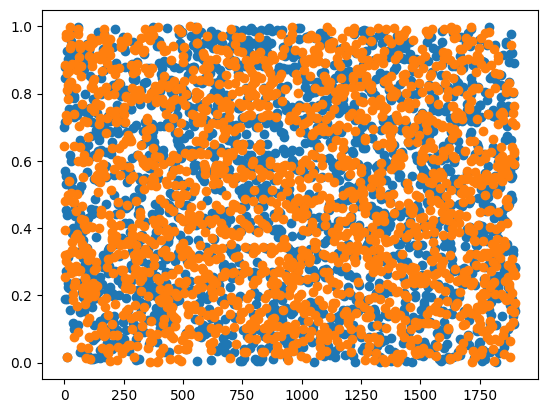

In [8]:
#Verificacion de normalizacion de los datos
plt.scatter(range(len(labels[:, 1])), labels[:,1])
plt.scatter(range(len(labels[:, 0])), labels[:,0])
plt.show()

Se realizarán 2 modelos de redes convolucionales.
El primero se implementará con las imágenes completas de los agujeros negros, que son las ya cargadas. Para el segundo modelo se usarán estas imágenes pero cortadas verticalmente en una región de la imagen.

Esto es con el objetivo de observar cuál de estas dos redes es más eficiente y ofrece mejores resultados.

Se procede a crear y visualizar el conjunto de datos recortado:

Tamaño de imagenes cortadas: (1900, 4, 84)


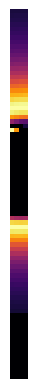

In [9]:
#split de datos cortados en el ecuador
tamañox, tamañoy = images_data.shape[1:]
ecuador = int(tamañox/2)
#Cut
images_data_cut = images_data[:, ecuador-2:ecuador+2,:]
print(f'Tamaño de imagenes cortadas: {images_data_cut.shape}')

plt.imshow(images_data_cut[0].T, origin='lower', cmap='inferno')
plt.axis('off')
plt.show()

Realizamos el split de los datos en datos de entrenamiento y de prueba, para ambos conjuntos de datos

In [10]:
#Split de datos
X_train_cut, X_test_cut, y_train_cut, y_test_cut = train_test_split(
    images_data_cut, labels, test_size=0.30, random_state=56)

X_train, X_test, y_train, y_test = train_test_split(
    images_data, labels, test_size=0.30, random_state=17)

## Red convolucional, imágenes completas

In [52]:
print(f'Tamaño entrenamiento datos: {X_train.shape}')
print(f'Tamaño entrenamiento targets: {y_train.shape}')
print(f'Tamaño test datos: {X_test.shape}')
print(f'Tamaño test targets: {y_test.shape}')

Tamaño entrenamiento datos: (1330, 150, 84)
Tamaño entrenamiento targets: (1330, 2)
Tamaño test datos: (570, 150, 84)
Tamaño test targets: (570, 2)


Se plantea la siguiente arquitectura:

In [53]:
#Modelo de red convolucional
modelo_completo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(150, 84, 1), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    #ARQUITECTURA
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=2), #numero de salidas
])

#compilar el modelo
modelo_completo.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['MeanAbsoluteError']
)

In [54]:
modelo_completo.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 82, 32)       320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 41, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 39, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 19, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 34, 17, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 8, 128)       

In [55]:
print('Entrenando ando...')
history_completo = modelo_completo.fit(
    X_train,
    y_train,
    steps_per_epoch=int(16),
    epochs=100,
    validation_data= (X_test, y_test),
    verbose=False
)
print('Mas preparado que un kumis')

Entrenando ando...
Mas preparado que un kumis


Tiempo de ejecución (en colab): +40min

Observamos cómo varía la función de pérdida y el error absoluto medio, en cada época

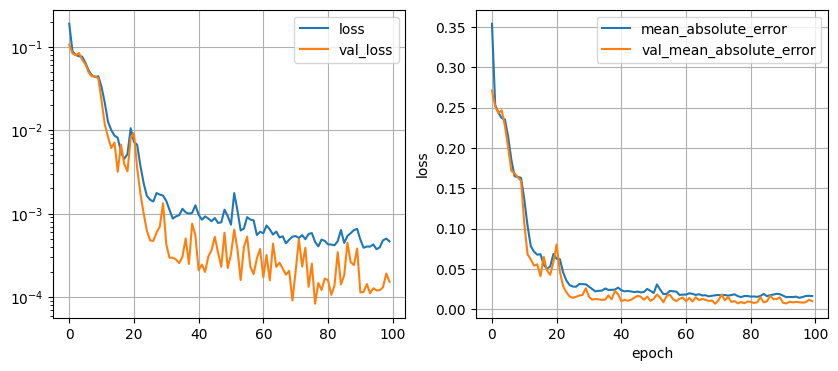

In [56]:
history_loss = history_completo.history['loss']
history_val_loss = history_completo.history['val_loss']
history_MAE = history_completo.history['mean_absolute_error']
history_val_MAE = history_completo.history['val_mean_absolute_error']
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(range(len(history_loss)) , history_loss, label = 'loss')
ax[0].plot(range(len(history_loss)) , history_val_loss, label = 'val_loss')
ax[1].plot(range(len(history_loss)) , history_MAE, label = 'mean_absolute_error')
ax[1].plot(range(len(history_loss)) , history_val_MAE, label = 'val_mean_absolute_error')
ax[0].grid(True)
ax[0].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[0].set_yscale('log')
ax[1].grid(True)
ax[1].legend()

Podemos concluir que no hay overfitting

Generamos las predicciones con los datos de prueba

In [57]:
predicciones_modelo_completo = modelo_completo.predict(X_test)

18/18 [==============================] - 2s 121ms/step


Finalmente realizamos una comparación de los valores predichos y los targets.

R^2 spin: 0.9987379835726458, Error Cuadrático Medio (MSE): 0.00010342016362606766
R^2 inclinación: 0.9977041902709999, Error Cuadrático Medio (MSE): 0.00020162564709044254


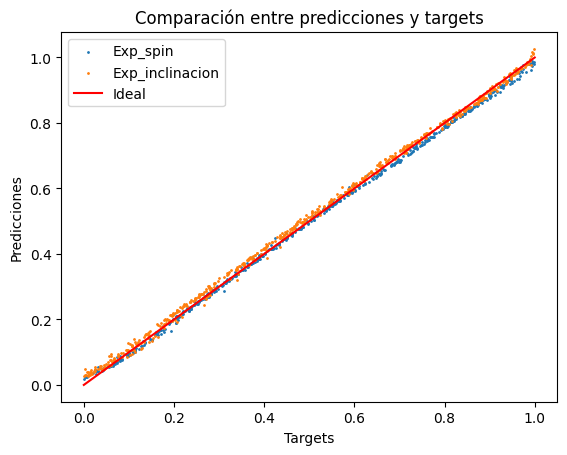

In [58]:
fig, ax = plt.subplots()
ax.scatter(y_test[:, 0], predicciones_modelo_completo[:, 0], label='Exp_spin', marker='.', s=4 )
ax.scatter(y_test[:, 1], predicciones_modelo_completo[:, 1], label='Exp_inclinacion', marker='.', s=4)
ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='r', label='Ideal')
ax.set_xlabel('Targets')
ax.set_ylabel('Predicciones')
ax.set_title('Comparación entre predicciones y targets')
ax.legend()
print(f'R^2 spin: {r2_score(y_test[:,0], predicciones_modelo_completo[:,0])}, Error Cuadrático Medio (MSE): {mean_squared_error(y_test[:,0], predicciones_modelo_completo[:,0])}')
print(f'R^2 inclinación: {r2_score(y_test[:,1], predicciones_modelo_completo[:,1])}, Error Cuadrático Medio (MSE): {mean_squared_error(y_test[:,1], predicciones_modelo_completo[:,1])}')

Con esto, se concluye que la red neuronal que usa las imágenes completas, tiene un muy buen comportamiento para la predicción del espín y el ángulo de inclinación. Sin embargo, el tiempo de ejecución es muy alto.

## Red para las imágenes recortadas

Construimos la red:

In [46]:
#Modelo de red convolucional CORTADO
modelo_cut = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(4, 84, 1), padding = "same", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), padding = "same", activation='relu'),
    #ARQUITECTURA
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=2), #numero de salidas
])

#compilar el modelo
modelo_cut.compile(
    optimizer= 'adam',
    loss='mean_squared_error',
    metrics=['MeanAbsoluteError']
)

In [47]:
modelo_cut.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 4, 84, 32)         320       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 42, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 42, 64)         18496     
                                                                 
 dropout_6 (Dropout)         (None, 2, 42, 64)         0         
                                                                 
 flatten_6 (Flatten)         (None, 5376)              0         
                                                                 
 dense_24 (Dense)            (None, 128)               688256    
                                                      

In [48]:
print('Entrenando ando...')
history_cut = modelo_cut.fit(
    X_train_cut,
    y_train_cut,
    steps_per_epoch = int(16),
    epochs = 100,
    validation_data = (X_test_cut, y_test_cut),
    verbose = False
)
print('Mas preparado que un kumis')

Entrenando ando...
Mas preparado que un kumis


Tiempo de ejecución < 1min

Observamos cómo varía la función de pérdida y el error absoluto medio, en cada época

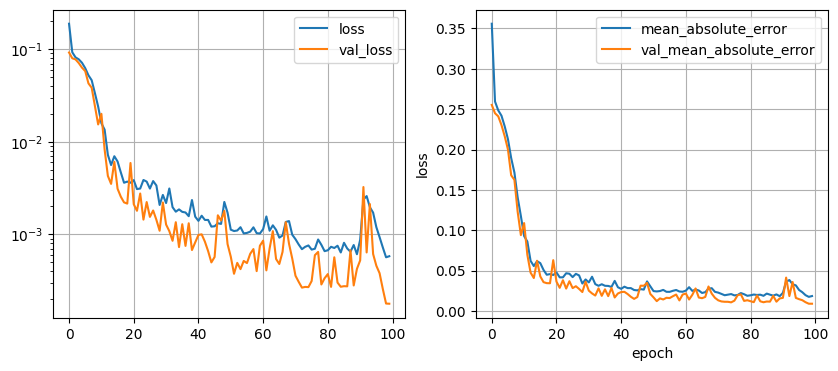

In [49]:
history_loss = history_cut.history['loss']
history_val_loss = history_cut.history['val_loss']
history_MAE = history_cut.history['mean_absolute_error']
history_val_MAE = history_cut.history['val_mean_absolute_error']
fig, ax = plt.subplots(1,2, figsize= (10,4))
ax[0].plot(range(len(history_loss)) , history_loss, label = 'loss')
ax[0].plot(range(len(history_loss)) , history_val_loss, label = 'val_loss')
ax[1].plot(range(len(history_loss)) , history_MAE, label = 'mean_absolute_error')
ax[1].plot(range(len(history_loss)) , history_val_MAE, label = 'val_mean_absolute_error')
ax[0].grid(True)
ax[0].legend()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[0].set_yscale('log')
ax[1].grid(True)
ax[1].legend()

Se observa que no hay overfitting

Realizamos las predicciones del modelo:

In [50]:
predicciones_modelo_cut = modelo_cut.predict(X_test_cut)

18/18 [==============================] - 0s 5ms/step


Finalmente comparamos los valores predichos con los targets.

R^2 spin: 0.9985733155627909, Error cuadrático medio (MSE): 0.00011504499961312688
R^2 inclinación: 0.9969360928265182, Error cuadrático medio (MSE): 0.00024019867178589154


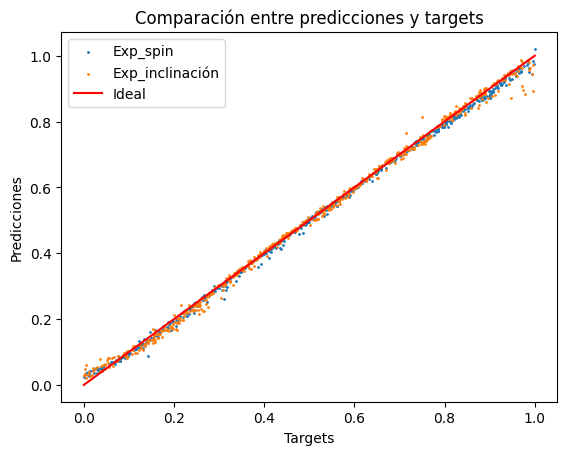

In [51]:
fig, ax = plt.subplots()
ax.scatter(y_test_cut[:, 0], predicciones_modelo_cut[:, 0], label='Exp_spin', marker='.', s=4 )
ax.scatter(y_test_cut[:, 1], predicciones_modelo_cut[:, 1], label='Exp_inclinación', marker='.', s=4)
ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='r', label='Ideal')
ax.set_xlabel('Targets')
ax.set_ylabel('Predicciones')
ax.set_title('Comparación entre predicciones y targets')
ax.legend()
print(f'R^2 spin: {r2_score(y_test_cut[:, 0], predicciones_modelo_cut[:, 0])}, Error cuadrático medio (MSE): {mean_squared_error(y_test_cut[:,0], predicciones_modelo_cut[:,0])}')
print(f'R^2 inclinación: {r2_score(y_test_cut[:, 1], predicciones_modelo_cut[:, 1])}, Error cuadrático medio (MSE): {mean_squared_error(y_test_cut[:,1], predicciones_modelo_cut[:,1])}')

Se concluye que en esta red, que usa las imágenes recortadas, el tiempo de entrenamiento se reduce considerablemente con respecto a la red anterior, y además mantiene resultados muy buenos para las predicciones del espín y del ángulo de inclinación.

## Códigos para comparar diferentes arquitecturas de modelos

modelo:0.0
16/16 [==============================] - 0s 4ms/step
modelo:1.1666666666666667
16/16 [==============================] - 0s 2ms/step
modelo:2.3333333333333335
16/16 [==============================] - 0s 2ms/step
modelo:3.5
16/16 [==============================] - 0s 2ms/step
modelo:4.666666666666667
16/16 [==============================] - 0s 2ms/step
modelo:5.833333333333334
16/16 [==============================] - 0s 2ms/step
modelo:7.0
16/16 [==============================] - 0s 2ms/step


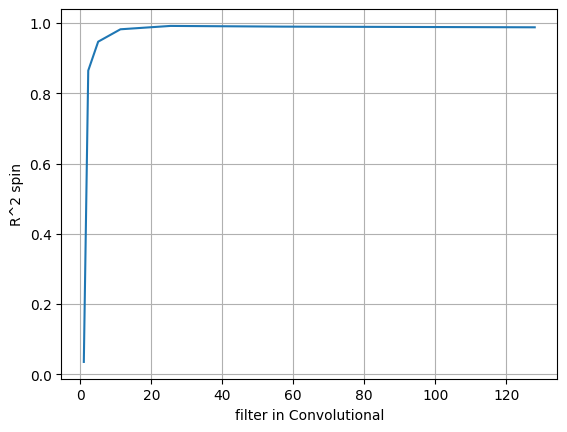

In [ ]:
N=7
rcuadrado=[]
Neuronas=[]
X_train, X_test, y_train, y_test = train_test_split(
        images_data_cut, labels, test_size=0.3, random_state=8)

for i in np.linspace(0,7,N):
    Neuronas.append(2**i)
    #Modelo de red convolucional CORTADO
    modelo = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), input_shape=(4,84,1), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        #ARQUITECTURA
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=int(128), activation='relu'),
        tf.keras.layers.Dense(units=int(128), activation='relu'),
        tf.keras.layers.Dense(units=int(128), activation='relu'),
        tf.keras.layers.Dense(units=2), #numero salidas
    ])
    #compilar el modelo
    modelo.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['MeanAbsoluteError']
    )
    print(f'modelo:{i}')
    history = modelo.fit(
        X_train,
        y_train,
        steps_per_epoch=int(2**i),
        epochs=100,
        validation_data=(X_test, y_test),
        verbose=False
    )
    predicciones = modelo.predict(X_test)
    rcuadradospin=r2_score(y_test[:,1], predicciones[:,1])
    rcuadrado.append(rcuadradospin)

fig, ax = plt.subplots()
ax.plot(Neuronas,rcuadrado)
ax.set_xlabel('filter in Convolutional')
ax.set_ylabel('R^2 spin')
ax.grid(True)

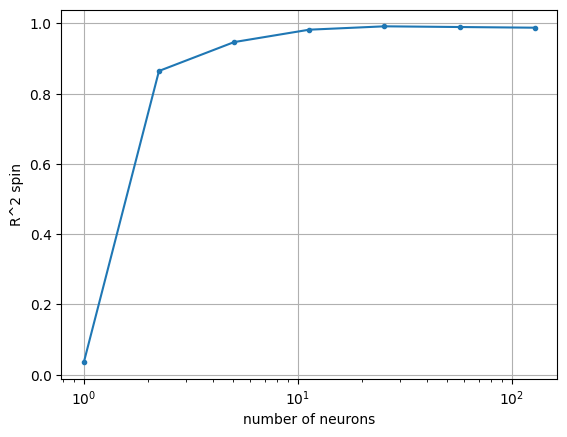

In [ ]:
fig, ax = plt.subplots()
ax.plot(Neuronas,rcuadrado, marker='.')
ax.set_xlabel('number of neurons')
ax.set_ylabel('R^2 spin')
ax.set_xscale('log')
#ax.set_ylim(0.94,1)
#ax.set_xlim(0,100)
ax.grid(True)